<a href="https://colab.research.google.com/github/yahal2005/Facial-Emotion-Recognition/blob/3-dt-classifiers-on-ck-dataset-hog/facial_emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import cv2
import numpy as np
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt
from skimage.feature import hog

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
base_path = '/content/drive/MyDrive/Colab_Notebooks/fer'

In [5]:
haarcascade_path = os.path.join(base_path, 'haarcascade_frontalface_default.xml')
face_cascade = cv2.CascadeClassifier(haarcascade_path)

In [6]:
def load_and_detect_faces(folder_path):
  images = []
  labels = []
  for label in os.listdir(folder_path):
    label_path = os.path.join(folder_path, label)
    if os.path.isdir(label_path):
      for img_file in os.listdir(label_path):
        img_path = os.path.join(label_path, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
          faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
          for (x, y, w, h) in faces:
            face_region = img[y:y+h, x:x+w]
            images.append(face_region)
            labels.append(label)
  return images,labels

In [7]:
def extract_hog_features(images):
  hog_features = []
  for img in images:
    img = cv2.resize(img, (64, 64))
    hog_feat = hog(img,orientations=8,pixels_per_cell=(8,8),cells_per_block=(2,2), block_norm='L2-Hys')
    hog_features.append(hog_feat)
  return np.array(hog_features)

In [11]:
train_folder_path = os.path.join(base_path, 'CK_dataset/train')
test_folder_path = os.path.join(base_path, 'CK_dataset/test')

X_train_faces, y_train = load_and_detect_faces(train_folder_path)
X_train_features = extract_hog_features(X_train_faces)

X_test_faces, y_test = load_and_detect_faces(test_folder_path)
X_test_features = extract_hog_features(X_test_faces)

In [12]:
tree_classifier = DecisionTreeClassifier(max_depth=10, random_state=42)
tree_classifier.fit(X_train_features, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [13]:
y_pred = tree_classifier.predict(X_test_features)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 44.06%
Confusion Matrix:
[[ 6  0  0 11  1  0]
 [ 0  1  0  2  3  1]
 [ 1  1 18  5  3  2]
 [ 2  6  1 14  3 10]
 [ 4  1  0  7  2  3]
 [ 2  1  3  6  1 22]]


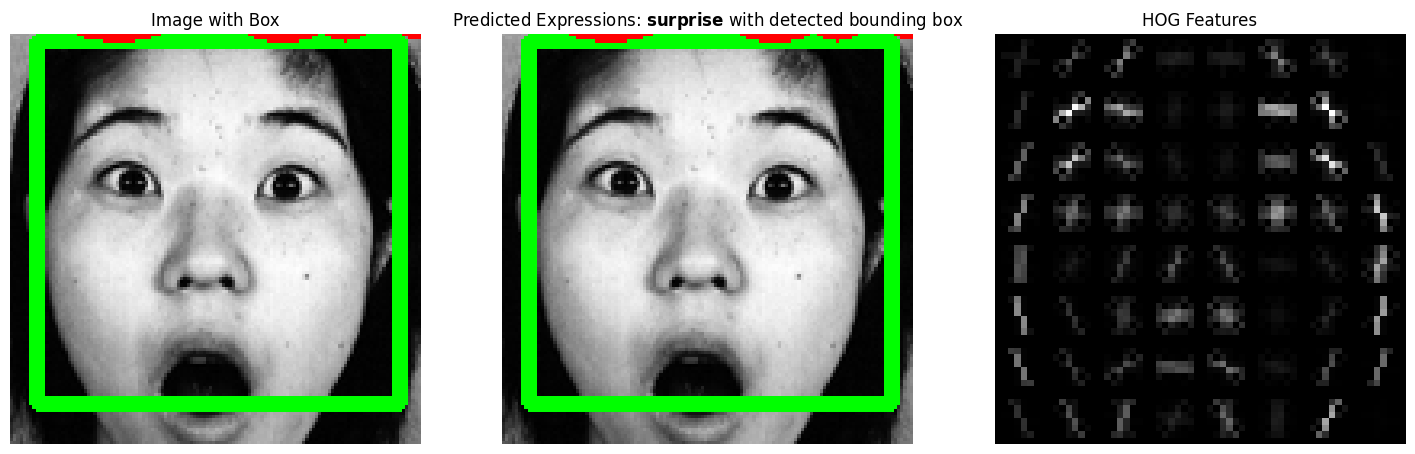

In [17]:
def extract_hog_features(img):
  img = cv2.resize(img, (64, 64))

  hog_features, hog_image = hog(img, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')
  return hog_features,hog_image

def predict_emotion_hog(image_path, model):
  img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
  if img is None:
    raise ValueError(f"Failed to load image from {image_path}")

  faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
  if len(faces) == 0:
    print("No face detected.")
    return

  (x,y,w,h) = faces[0]
  face_region = img[y:y+h, x:x+w]
  features,hog_image = extract_hog_features(face_region)
  features = features.reshape(1, -1)

  predicted_expression = model.predict(features)[0]

  img_rgb = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

  img_with_box = img_rgb.copy()
  cv2.rectangle(img_with_box, (x, y), (x + w, y + h), (0, 255, 0), 3)
  cv2.putText(img_with_box,predicted_expression, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 0, 0), 20)
  plt.figure(figsize=(18, 6))

  plt.subplot(1, 3, 1)
  plt.imshow(img_with_box)
  plt.title('Image with Box')
  plt.axis('off')

  plt.subplot(1, 3, 2)
  plt.imshow(img_with_box)
  plt.title(f'Predicted Expressions: $\\mathbf{{{predicted_expression}}}$ with detected bounding box')
  plt.axis('off')

  plt.subplot(1, 3, 3)
  plt.imshow(hog_image, cmap='gray')
  plt.title('HOG Features')
  plt.axis('off')

  plt.show()



image_path = os.path.join(base_path, 'testimages/23.tiff')
predict_emotion_hog(image_path, tree_classifier)
